In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from keras.preprocessing.image import  img_to_array, load_img 
from keras.preprocessing import image

In [2]:
image_dir = Path('/kaggle/input/food-classification')

filepaths = list(image_dir.glob(r'**/*.jpg'))

#using glob to target particular image files



labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

#separating the class names from the file paths and saving in labels



filepaths = pd.Series(filepaths, name='Filepath').astype(str)

labels = pd.Series(labels, name='Label')



images = pd.concat([filepaths, labels], axis=1)



category_samples = []

for category in images['Label'].unique():

    category_slice = images.query("Label == @category")

    category_samples.append(category_slice.sample(130, random_state=1))

#concatenate category samples

image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

#sample 100% of the data again after shuffling




In [3]:
image_df['Label'].value_counts()

Label
chole_bhature    130
chai             130
kaathi_rolls     130
momos            130
dal_makhani      130
kulfi            130
pav_bhaji        130
fried_rice       130
paani_puri       130
pakode           130
samosa           130
idli             130
masala_dosa      130
butter_naan      130
jalebi           130
pizza            130
kadai_paneer     130
dhokla           130
burger           130
Name: count, dtype: int64

In [4]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)
#70% training 30% test
#since we are shuffling, random state = 1

In [5]:
#limited memory so we train in batches to recycle memory
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [6]:
#this train_images will be passed into our fit function
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
#default image size for mobilenetV2 is 224x224
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
#shuffle after each epoch
    seed=42,
    subset='training'
#only available if validation_split is used to specify whether to use validation subset 0.2 or training subset

)

validation_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 1384 validated image filenames belonging to 19 classes.
Found 345 validated image filenames belonging to 19 classes.
Found 741 validated image filenames belonging to 19 classes.


In [7]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
#we dont wanna keep the classification layer of the og dataset on which the model is pretrained we just want our dataset's classification layer
#originally trained on imagenet  dataset 1000 classes
    weights='imagenet',
#to keep the same weights
    pooling='avg'
#output is 1d now
)

pretrained_model.trainable = False
#to not change the original imagenet weights
#We are transfering learning of the model so we keep it as it is
#This model is good for feature extraction
#Use the same model, remove the top layer, use your own top layer i.e. classes, dataset

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#128 neurons
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(19, activation='softmax')(x)
#classification layer
model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,440,915 (9.31 MB)

 Trainable params: 182,931 (714.57 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [9]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    #as classes are encoded as vectors by the generator so we use categorical_crossentropy
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=validation_images,
    epochs=10,
    #INCREASE NO. OF EPOCHS TO INCREASE ACCURACY (77.46% ACCURACY ACHIEVED ON 100 EPOCHS)
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            #when validation loss stops improving for 3 consecutive epochs training will be stopped and best epochs weights are restored
            restore_best_weights=True,
            mode='min'
        )
    ]
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1731817695.061841     107 service.cc:145] XLA service 0x7cace0002630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731817695.061904     107 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/44 ━━━━━━━━━━━━━━━━━━━━ 10:53 15s/step - accuracy: 0.1250 - loss: 2.8026

I0000 00:00:1731817699.849549     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


44/44 ━━━━━━━━━━━━━━━━━━━━ 52s 858ms/step - accuracy: 0.3101 - loss: 2.4138 - val_accuracy: 0.6087 - val_loss: 1.3069
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 510ms/step - accuracy: 0.7752 - loss: 0.8248 - val_accuracy: 0.7623 - val_loss: 0.9192
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 550ms/step - accuracy: 0.8785 - loss: 0.4305 - val_accuracy: 0.7623 - val_loss: 0.8432
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 553ms/step - accuracy: 0.9284 - loss: 0.2762 - val_accuracy: 0.7739 - val_loss: 0.8177
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 531ms/step - accuracy: 0.9742 - loss: 0.1277 - val_accuracy: 0.8000 - val_loss: 0.7621
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 528ms/step - accuracy: 0.9968 - loss: 0.0689 - val_accuracy: 0.8087 - val_loss: 0.7938
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 528ms/step - accuracy: 0.9998 - loss: 0.0370 - val_accuracy: 0.8261 - val_loss: 0.7668
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 528ms/step - accuracy: 1.0000 - loss: 0.0225 - val_accuracy: 0.831

In [10]:
model.save("my_model.h5")

results = model.evaluate(test_images, verbose=0)
#gives loss and accuracy for test set
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Accuracy: 79.49%


In [11]:
predictions = np.argmax(model.predict(test_images), axis=1)

cm = confusion_matrix(test_images.labels, predictions)
clr = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 508ms/step


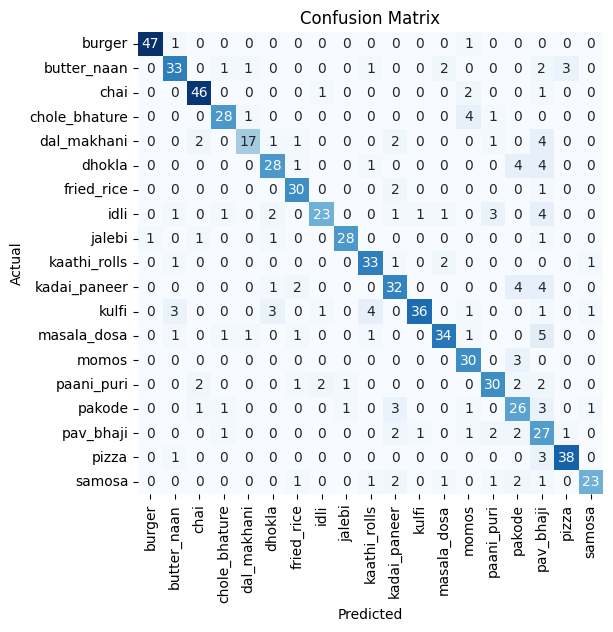

In [12]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(19) + 0.5, labels=test_images.class_indices, rotation=90)
plt.yticks(ticks=np.arange(19) + 0.5, labels=test_images.class_indices, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
print("Classification Report:\n----------------------\n", clr)

Classification Report:
----------------------
                precision    recall  f1-score   support

       burger       0.98      0.96      0.97        49
  butter_naan       0.80      0.77      0.79        43
         chai       0.88      0.92      0.90        50
chole_bhature       0.85      0.82      0.84        34
  dal_makhani       0.85      0.61      0.71        28
       dhokla       0.78      0.74      0.76        38
   fried_rice       0.81      0.91      0.86        33
         idli       0.85      0.62      0.72        37
       jalebi       0.93      0.88      0.90        32
 kaathi_rolls       0.80      0.87      0.84        38
 kadai_paneer       0.71      0.74      0.73        43
        kulfi       0.95      0.72      0.82        50
  masala_dosa       0.85      0.76      0.80        45
        momos       0.73      0.91      0.81        33
   paani_puri       0.79      0.75      0.77        40
       pakode       0.60      0.70      0.65        37
    pav_bhaji    

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
